#**Trabajo Integrador Final Curso Data Science UTN 2024**


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = "/content/drive/MyDrive/UTN data/TFI/CSVs/"

#Dataset elegido: seguro médico

##Contexto
La industria de los seguros médicos es compleja y dinámica, con costos que varían significativamente según diversos factores que caracterizan a los asegurados. Comprender estos factores y predecir el precio del seguro médico en dólares, con precisión, puede ser de gran valor para las compañías de seguros, los clientes y las autoridades regulatorias.

##Hipótesis
"La **edad** es el factor más influyente en el valor del seguro de salud".

Analizaremos si esta hipótesis es correcta e intentaremos desarrollar un modelo que permita predecir el costo de la póliza para nuevos afiliados en base a su historial y características personales.

In [ ]:
# Cargamos el archivo
archivo = "insurance.csv"
ruta_archivo = os.path.join(ruta, archivo)

In [ ]:
seguros = pd.read_csv(ruta_archivo)
seguros

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


##Referencias

Age ("Edad"): edad del afiliado (años)

Sex ("Sexo"): sexo del afiliado (Masculino, Femenino)

BMI ("IMC"): índice de masa corporal del afiliado (kg/m²)

Children ("Hijos"): cantidad de hijos del afiliado

Smoker ("Fumador"): tabaquismo del afiliado (No, Sí)

Region ("Región"): región de residencia del afiliado (southwest "SO", southeast "SE", northwest "NO", northeast "NE")

Charges ("Costo"): valor de la póliza anual (USD)


##EDA

###Observación inicial del dataframe

In [ ]:
seguros.shape

(1338, 7)

In [ ]:
# Vemos los nombres de todas las columnas
seguros.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

El conjunto de datos denominado "insurance.csv" contiene 7 columnas y 1338 registros.

Las columnas son:
* Age: Edad del asegurado.
* Sex: Tipo del sexo.
* Bmi: Indice de masa corporal.
* Children: hijos.
* Smoker: Fumador.
* Region: Pais.
* Charges: Costo


In [ ]:
# Vemos los valores de región
seguros['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [ ]:
# Traducimos el dataset a español

# Definimos un diccionario de mapeo de nombres de columnas
column_mapping = {'age':'Edad',
                  'sex': 'Sexo',
                  'bmi':'IMC',
                  'children': 'Hijos',
                  'smoker':'Fumador',
                  'region': 'Región',
                  'charges':'Costo'}

# Con el método rename, cambiamos los nombres de las columnas
seguros = seguros.rename(columns=column_mapping)

# Con el método replace, cambiamos los valores en la columna "Sexo", "Fumador" y "Región"
seguros['Sexo'] = seguros['Sexo'].replace({'male': 'Masculino', 'female': 'Femenino'})
seguros['Fumador'] = seguros['Fumador'].replace({'yes': 'Sí', "no": "No"})
seguros['Región'] = seguros['Región'].replace({'southwest': "SO", 'southeast': "SE",
                                              'northwest': "NO", 'northeast': "NE"})

# Chequeamos el DataFrame en español
seguros

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo
0,19,Femenino,27.900,0,Sí,SO,16884.92400
1,18,Masculino,33.770,1,No,SE,1725.55230
2,28,Masculino,33.000,3,No,SE,4449.46200
3,33,Masculino,22.705,0,No,NO,21984.47061
4,32,Masculino,28.880,0,No,NO,3866.85520
...,...,...,...,...,...,...,...
1333,50,Masculino,30.970,3,No,NO,10600.54830
1334,18,Femenino,31.920,0,No,NE,2205.98080
1335,18,Femenino,36.850,0,No,SE,1629.83350
1336,21,Femenino,25.800,0,No,SO,2007.94500


In [ ]:
# Redondeamos la columna Costo a dos decimales
seguros['Costo'] = seguros['Costo'].round(2)
seguros['Costo']

0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.94
1337    29141.36
Name: Costo, Length: 1338, dtype: float64

In [ ]:
seguros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Edad     1338 non-null   int64  
 1   Sexo     1338 non-null   object 
 2   IMC      1338 non-null   float64
 3   Hijos    1338 non-null   int64  
 4   Fumador  1338 non-null   object 
 5   Región   1338 non-null   object 
 6   Costo    1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


El dataframe consta de 1338 registros, sin datos nulos.
En cuanto tipo de datos, podemos identificar que las columnas 'Edad' e 'Hijos' son de tipo entero (int64); por su parte 'IMC' y 'Costo' son números decimales (float64); y por último 'Sexo', 'Fumador' y 'Región' son de tipo texto (object).

In [ ]:
seguros.describe()

,Edad,IMC,Hijos,Costo
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422280
std,14.049960,6.098187,1.205493,12110.011259
min,18.000000,15.960000,0.000000,1121.870000
25%,27.000000,26.296250,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.693750,2.000000,16639.915000
max,64.000000,53.130000,5.000000,63770.430000


Identificamos métricas estadísticas para un mejor análisis.
A priori, no se observan inconsistencias y/o valores faltantes; de todas formas, esto se corroborará en los siguientes pasos.

La columna edad, parece tener una distribución simétrica (dado que los valores de media y mediana son similares). La mediana de la edad se ubica en los 39 años, el mínimo es 18 años y el máximo es 64 años.  El desvío estándar es de 14 años. El 75% de las personas, tienen hasta 51 años.

El IMC presenta una distribución simétrica (dado que los valores de media y mediana son similares). La mediana del IMC se ubica en 30.4 k/m², el mínimo es 15.96 y el máximo es 53.13.  El desvío estándar es de 6.1. El 75% de las personas, tienen hasta 34.69.

El número de hijos presenta una distribución simétrica (dado que los valores de media y mediana son similares). La mediana del número de hijos, se ubica en 1, el mínimo es 0 y el máximo es 5. El desvío estándar es de 1.2. El 75% de las personas, tienen hasta 2 hijos.

El costo presenta una distribución asimétrica a la derecha (ya que la media es mayor a la mediana). La mediana del costo, se ubica en los 9382.03 USD, el mínimo es de 1121.87 USD y el máximo es 63770.43 USD.  El desvío estándar es de 12110.01 USD. El 75% de las personas, abona hasta 16639.92 USD por año.

###Modificacion del dataframe

####Agregamos columnas

Se decide generar columnas binarias para realizar el análisis del tabaquismo (no fumadores = 0, fumadores = 1), así como del sexo (masculino = 0, femenino = 1).

Además, se genera un código numérico para las regiones. Los números se asignan en sentido horario comenzando desde el Norte (NE:0, SE:1 SO:2 NO:3.

#####Nueva columna Código Fumador

* No fumador=0
* Fumador=1

In [ ]:
seguros['Fumador_cod'] = seguros['Fumador'].apply(lambda x: 0 if x == 'No' else 1)
seguros.head()

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo,Fumador_cod
0,19,Femenino,27.900,0,Sí,SO,16884.92,1
1,18,Masculino,33.770,1,No,SE,1725.55,0
2,28,Masculino,33.000,3,No,SE,4449.46,0
3,33,Masculino,22.705,0,No,NO,21984.47,0
4,32,Masculino,28.880,0,No,NO,3866.86,0


#####Nueva columna Código Sexo

* Masculino=0
* Femenino=1

In [ ]:
seguros['Sexo_cod'] = seguros['Sexo'].apply(lambda x: 0 if x == 'Masculino' else 1)
seguros.head()

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo,Fumador_cod,Sexo_cod
0,19,Femenino,27.900,0,Sí,SO,16884.92,1,1
1,18,Masculino,33.770,1,No,SE,1725.55,0,0
2,28,Masculino,33.000,3,No,SE,4449.46,0,0
3,33,Masculino,22.705,0,No,NO,21984.47,0,0
4,32,Masculino,28.880,0,No,NO,3866.86,0,0


#####Nueva columna Código Región

* NE=0
* SE=1
* SO=2
* NO=3

In [ ]:
seguros['Región_cod'] = seguros['Región'].apply(lambda x: 0 if x == 'NE' else (1 if x == 'SE' else (2 if x == 'SO' else 3)))
seguros.head()

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo,Fumador_cod,Sexo_cod,Región_cod
0,19,Femenino,27.900,0,Sí,SO,16884.92,1,1,2
1,18,Masculino,33.770,1,No,SE,1725.55,0,0,1
2,28,Masculino,33.000,3,No,SE,4449.46,0,0,1
3,33,Masculino,22.705,0,No,NO,21984.47,0,0,3
4,32,Masculino,28.880,0,No,NO,3866.86,0,0,3


#####Nueva columna Rango Etario

Con la información proporcionada por el conjunto de datos, nos parece importante agregar una columna de Rango Etario, con el objeto de analizar en qué medida la variable 'Edad' influye sobre el seguro médico.

Se decide dividir las edades en intervalos de 5 años, para facilitar el análisis.

In [ ]:
# Definimos los límites de los intervalos de edad
edad_minima = 15
edad_maxima = seguros['Edad'].max()
intervalos = range(edad_minima, edad_maxima + 6, 5)

# Definimos las etiquetas de los intervalos
etiquetas = [f'{i}-{i+4}' for i in range(edad_minima, edad_maxima + 1, 5)]

# Creamos una nueva columna de rango etario
seguros['Rango_Etario'] = pd.cut(seguros['Edad'], bins=intervalos, labels=etiquetas, right=False)

# Mostramos el dataframe con la nueva columna
seguros.head(10)

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario
0,19,Femenino,27.900,0,Sí,SO,16884.92,1,1,2,15-19
1,18,Masculino,33.770,1,No,SE,1725.55,0,0,1,15-19
2,28,Masculino,33.000,3,No,SE,4449.46,0,0,1,25-29
3,33,Masculino,22.705,0,No,NO,21984.47,0,0,3,30-34
4,32,Masculino,28.880,0,No,NO,3866.86,0,0,3,30-34
5,31,Femenino,25.740,0,No,SE,3756.62,0,1,1,30-34
6,46,Femenino,33.440,1,No,SE,8240.59,0,1,1,45-49
7,37,Femenino,27.740,3,No,NO,7281.51,0,1,3,35-39
8,37,Masculino,29.830,2,No,NE,6406.41,0,0,0,35-39
9,60,Femenino,25.840,0,No,NO,28923.14,0,1,3,60-64


#####Nueva columna Rango IMC

El diagnóstico del sobrepeso y la obesidad se efectúa midiendo el peso y la estatura de las personas y calculando el índice de masa corporal (IMC): peso (kg)/estatura² (m²). Este índice es un marcador indirecto de la grasa corporal, y existen mediciones adicionales, como el perímetro de la cintura, que pueden ayudar a diagnosticar la obesidad.

En el caso de los adultos, la OMS define el sobrepeso y la obesidad de acuerdo con estos parámetros:
* Bajo peso, si el IMC es menor a 18.0
* Peso normal, si el IMC es de 18.0 a 24.9
* Sobrepeso, si el IMC es de 25.0 a 29.9
* Obesidad clase 1 (de bajo riesgo), si el IMC es de 30 a 34.9
* Obesidad clase 2 (riesgo moderado), si el IMC es de 35 a 39.9
* Obesidad clase 3 (de alto riesgo), si el IMC es igual o mayor a 40

Con la información proporcionada por el conjunto de datos, nos parece importante agregar una columna de Rango IMC, con el objeto de analizar en qué medida la variable 'IMC' influye sobre el costo del seguro médico.

Se decide dividir los valores en intervalos de 5, de acuerdo a los criterios de la OMS mencionados anteriormente.

In [ ]:
# Definimos los límites de los intervalos de IMC
IMC_minimo = 15
IMC_maximo = 49
intervalos = range(IMC_minimo, IMC_maximo +6, 5)

# Definimos las etiquetas de los intervalos
etiquetas = [f'{i}-{i+4}' for i in range(IMC_minimo, IMC_maximo + 1, 5)]

# Creamos una nueva columna de rango IMC
seguros['Rango_IMC'] = pd.cut(seguros['IMC'], bins=intervalos, labels=etiquetas, right=False)

# Mostramos el dataframe con la nueva columna
seguros.head(10)

,Edad,Sexo,IMC,Hijos,Fumador,Región,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
0,19,Femenino,27.900,0,Sí,SO,16884.92,1,1,2,15-19,25-29
1,18,Masculino,33.770,1,No,SE,1725.55,0,0,1,15-19,30-34
2,28,Masculino,33.000,3,No,SE,4449.46,0,0,1,25-29,30-34
3,33,Masculino,22.705,0,No,NO,21984.47,0,0,3,30-34,20-24
4,32,Masculino,28.880,0,No,NO,3866.86,0,0,3,30-34,25-29
5,31,Femenino,25.740,0,No,SE,3756.62,0,1,1,30-34,25-29
6,46,Femenino,33.440,1,No,SE,8240.59,0,1,1,45-49,30-34
7,37,Femenino,27.740,3,No,NO,7281.51,0,1,3,35-39,25-29
8,37,Masculino,29.830,2,No,NE,6406.41,0,0,0,35-39,25-29
9,60,Femenino,25.840,0,No,NO,28923.14,0,1,3,60-64,25-29


####Borramos las columnas redundantes

Ya codificamos las columnas fumador, sexo, y región, y pudimos comprobar en el dataframe que los códigos se asignaron de manera correcta.

Procedemos a eliminar las columnas originales de tipo object para que queden solamente las numéricas.

In [ ]:
seguros.drop(['Fumador', 'Sexo','Región'], axis=1, inplace=True)
seguros.head()

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
0,19,27.900,0,16884.92,1,1,2,15-19,25-29
1,18,33.770,1,1725.55,0,0,1,15-19,30-34
2,28,33.000,3,4449.46,0,0,1,25-29,30-34
3,33,22.705,0,21984.47,0,0,3,30-34,20-24
4,32,28.880,0,3866.86,0,0,3,30-34,25-29


#####Verificamos el dataframe luego de aplicarle las modificaciones

In [ ]:
seguros.shape
seguros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Edad          1338 non-null   int64   
 1   IMC           1338 non-null   float64 
 2   Hijos         1338 non-null   int64   
 3   Costo         1338 non-null   float64 
 4   Fumador_cod   1338 non-null   int64   
 5   Sexo_cod      1338 non-null   int64   
 6   Región_cod    1338 non-null   int64   
 7   Rango_Etario  1338 non-null   category
 8   Rango_IMC     1335 non-null   category
dtypes: category(2), float64(2), int64(5)
memory usage: 76.6 KB


####**Conclusiones iniciales**
Luego de las primeras modificaciones, el dataframe consta de 9 columnas y 1338 registros.
Dentro de las columnas, contamos con 5 columnas con datos numéricos enteros, 2 columnas con datos decimales y dos columnas categóricas (rango etario y rango IMC).

Las columnas son:

* Edad: edad del afiliado [int64]
* IMC: índice de masa corporal del afiliado [float64]
* Hijos: cantidad de hijos del afiliado [int64]
* Costo: valor de la póliza anual [float64]
* Fumador_cod: tabaquismo del afiliado (0= No, 1= Sí) [int64]
* Sexo_cod: sexo del afiliado (0= Masculino, 1= Femenino) [int64]
* Región_cod: región de residencia del afiliado (1= NE, 2= SE, 3= SO, 4= NO) [int64]
* Rango_Etario: rango de edad del afiliado, en intervalos de 5 años entre 15 y 65. [category]
* Rango_IMC: rango de IMC del afiliado, en intervalos de 5 entre 15 y 49. [category]

Podemos clasificar las columnas en:
* **Dimensiones:** Una dimensión es una variable que implica una descripción, característica, funcionalidad o aspecto de los datos: edad, IMC, hijos, fumador_cod, sexo_cod, región_cod, rango_etario, rango_IMC.
* **Métricas:** Una métrica es cualquier tipo de variable que pueda ser usada para medir el desempeño de algún aspecto del proyecto que sea importante y querramos controlar: costo.

Las columnas edad, IMC e hijos parecen tener una distribución simétrica, mientras que costo presenta una distribución asimétrica a la derecha.

####Guardado del dataframe modificado

Procedemos a guardar un nuevo csv donde se hayan aplicado los cambios realizados, para evitar correr todo el notebook cada vez que queramos trabajar en él.

In [ ]:
# Nombre del nuevo archivo CSV
seguros2 = "seguros_2.csv"

# Combinamos la ruta del directorio y el nombre del nuevo archivo
ruta_seguros2= os.path.join(ruta, seguros2)

# Guardamos el nuevo archivo CSV en la misma ruta
seguros.to_csv(ruta_seguros2, index=False)

###Data Wrangling por columnas

In [ ]:
# Cargamos el csv con las modificaciones del EDA
seguros = pd.read_csv(ruta_seguros2)
seguros.head()

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
0,19,27.900,0,16884.92,1,1,2,15-19,25-29
1,18,33.770,1,1725.55,0,0,1,15-19,30-34
2,28,33.000,3,4449.46,0,0,1,25-29,30-34
3,33,22.705,0,21984.47,0,0,3,30-34,20-24
4,32,28.880,0,3866.86,0,0,3,30-34,25-29


####Edad

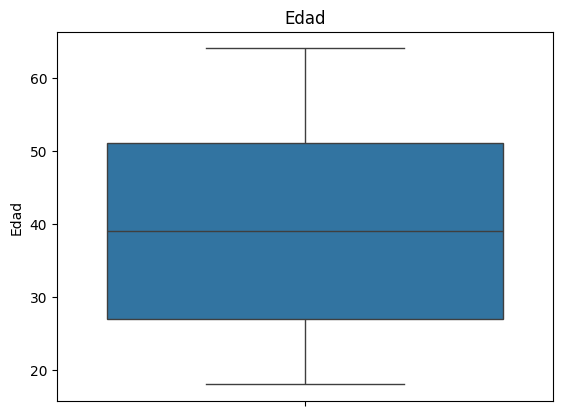

In [ ]:
sns.boxplot(data=seguros, y= 'Edad')
plt.title("Edad")

plt.show()

La edad promedio es de 39 años. El mínimo es 18 años y el máximo es 64 años. No hay outliers.

####Sexo

In [ ]:
# Recuento de distribucion por sexo: 0- Masculino, 1- Femenino
rto_masc = seguros[seguros['Sexo_cod']==0].value_counts().sum()
rto_fem = seguros[seguros['Sexo_cod']==1].value_counts().sum()
print(f'Hombres: {rto_masc}, mujeres: {rto_fem}')

Hombres: 673, mujeres: 662


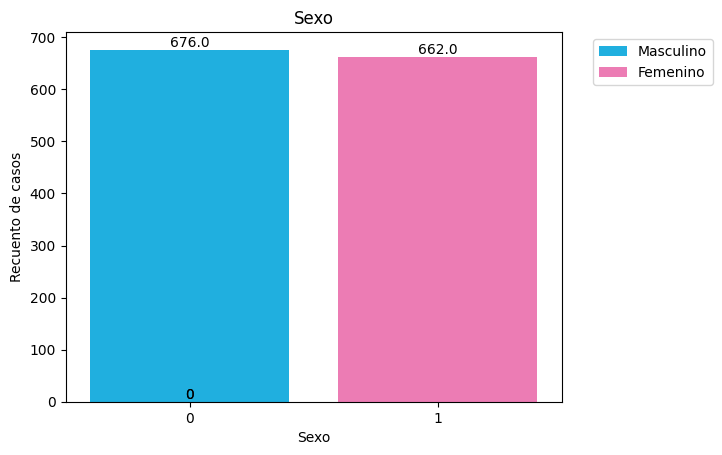

In [ ]:
# Definimos colores y etiquetas
labels = ['Masculino','Femenino']
custom_colors1 = {1: 'hotpink', 0: 'deepskyblue'}

# Creamos gráfico de barras
ax =sns.countplot(data=seguros, x="Sexo_cod", hue='Sexo_cod', palette=custom_colors1)

# Customización del gráfico
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Sexo')
plt.legend(labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Sexo')
plt.ylabel('Recuento de casos')

# Mostramos el gráfico
plt.show()

El dataframe se compone de 676 registros masculinos y 662 femeninos.

####IMC

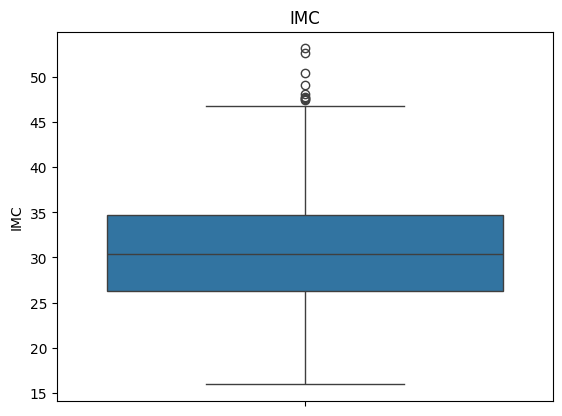

In [ ]:
sns.boxplot(data=seguros, y= 'IMC')
plt.title("IMC")

plt.show()

El IMC promedio es de 30.66. El mínimo es de 16 y el máximo de 53. Sin embargo, observamos que aparecen outliers por encima de un valor aproximado de 47.

In [ ]:
# Calculamos el mínimo y máximo inlier
Q1 = np.percentile(seguros['IMC'], 25)
Q3 = np.percentile(seguros['IMC'], 75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print('Mínimo inlier:', limite_inferior,'\nMáximo inlier:', limite_superior)

Mínimo inlier: 13.7 
Máximo inlier: 47.290000000000006


In [ ]:
# Contamos los registros con outliers en IMC
cantidad_supra = (seguros['IMC'] > 46.7).sum()
print(f'Por encima: {cantidad_supra}')

Por encima: 10


Al ser pocos registros, decidimos imputar los valores de la media, en base a que esta variable contiene datos homogéneos.

In [ ]:
# Reemplazamos los outliers de IMC por el valor de la media
seguros['IMC'] = seguros['IMC'].apply(lambda x: 30.66 if x >= 46.7 else x)

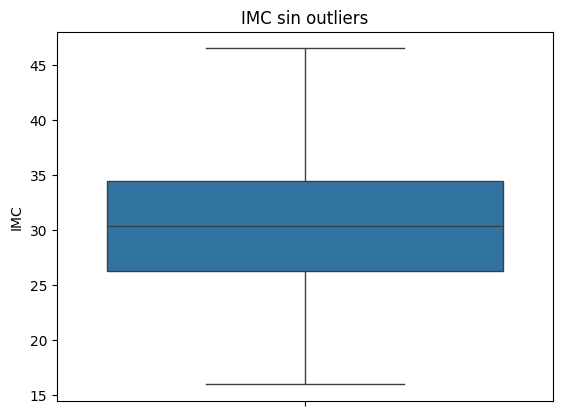

In [ ]:
# Chequeamos nuevamente el boxplot
sns.boxplot(data=seguros, y= 'IMC')
plt.title("IMC sin outliers")

plt.show()

In [ ]:
seguros['IMC'].describe()

count    1338.000000
mean       30.514159
std         5.866639
min        15.960000
25%        26.296250
50%        30.400000
75%        34.430000
max        46.530000
Name: IMC, dtype: float64

Luego de reimputar los outliers, el IMC promedio es de 30.51. El mínimo es de 15.96 y el máximo de 46.53.

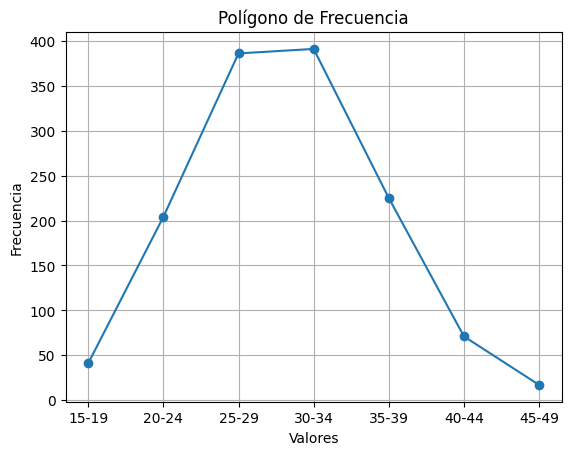

In [ ]:
frecuencias = seguros['Rango_IMC'].value_counts().sort_index()

plt.plot(frecuencias.index, frecuencias.values, marker='o')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Polígono de Frecuencia')
plt.grid(True)
plt.show()

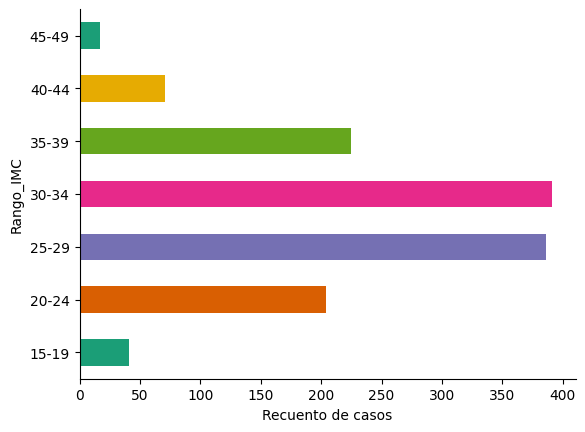

In [ ]:
seguros.groupby('Rango_IMC').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.xlabel('Recuento de casos')
plt.show()

Tanto en el polígono de frecuencia como en el gráfico de barras horizontales observamos el recuento de casos para cada rango de IMC, siendo el rango más frecuente el de 30-34 (aproximadamente 400 casos), seguido por el el rango de 25-29.

Por otra parte, los rangos menos frecuentes son los extremos (15-19 y 45-49).

####Hijos

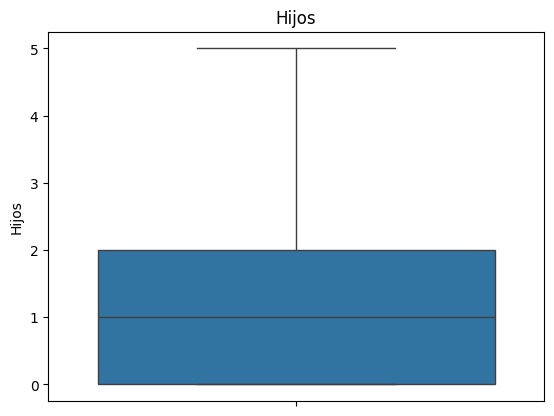

In [ ]:
sns.boxplot(data=seguros, y= 'Hijos')
plt.title("Hijos")

plt.show()

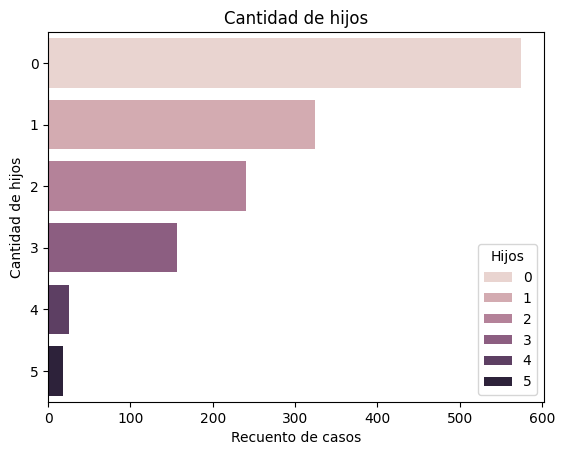

In [ ]:
sns.countplot(data=seguros, y= 'Hijos', hue='Hijos')
plt.title("Cantidad de hijos")
plt.xlabel("Recuento de casos")
plt.ylabel("Cantidad de hijos")
plt.show()

Observamos que casi la mitad de los afiliados no tienen hijos, y para los que sí los tienen, la cantidad varía de 1 a 5 en orden decreciente.

####Fumador

In [ ]:
# Recuento de fumadores
rto_no_fum = seguros[seguros['Fumador_cod']==0].value_counts().sum()
rto_fum = seguros[seguros['Fumador_cod']==1].value_counts().sum()
print(f'No fumadores: {rto_no_fum}, Fumadores: {rto_fum}')

No fumadores: 1062, Fumadores: 273


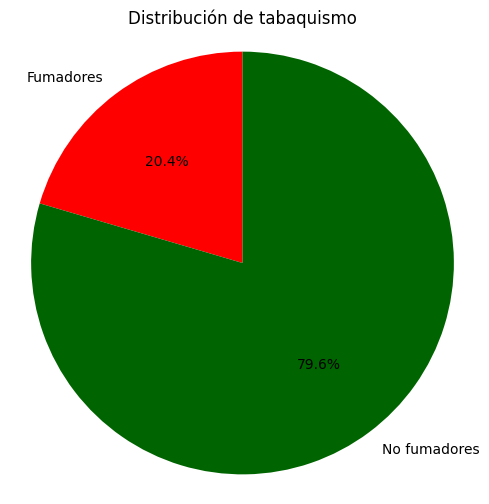

In [ ]:
# Gráfico de distribución según tabaquismo
valores = [rto_fum, rto_no_fum]
labels = ['Fumadores','No fumadores']
colors = ['red','darkgreen']

plt.figure(figsize=(6, 6))
plt.pie(valores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de tabaquismo')
plt.axis('equal')

plt.show()

En esta muestra observamos que el 20.4% de la población fuma, mientras que el 79.6% no fuma.

####Región

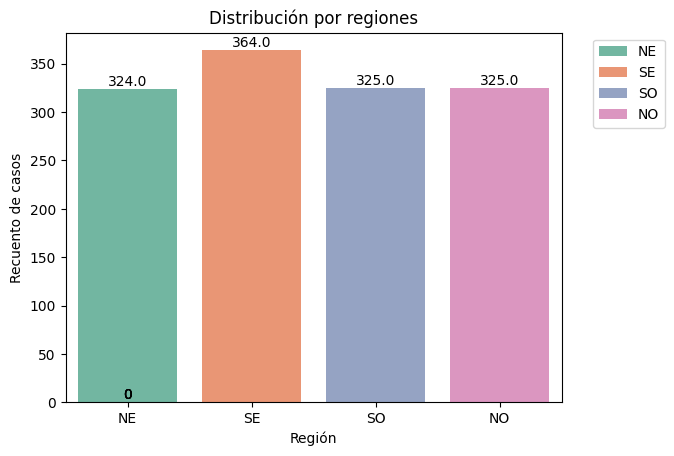

In [ ]:
ax = sns.countplot(data=seguros, x= 'Región_cod', hue='Región_cod', palette='Set2')
labels2=['NE','SE','SO','NO']

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, 5), textcoords='offset points')
plt.title("Distribución por regiones")
plt.xlabel("Región")
plt.ylabel("Recuento de casos")
plt.legend(labels=labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(range(len(labels2)))
ax.set_xticklabels(labels2)

plt.show()

Observamos que la región Sudeste presenta ligeramente más registros que las demás (357 Sudeste y alrededor de 325 el resto de las regiones).

####Costo

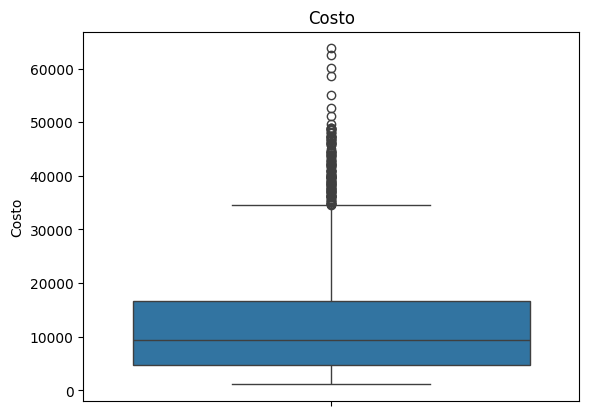

In [ ]:
sns.boxplot(data=seguros, y= 'Costo')
plt.title("Costo")

plt.show()

Observamos que en Costo tenemos una gran cantidad de outliers, es decir, hay mucha gente que paga una póliza más alta que el resto.

In [ ]:
# Calculamos el máximo inlier
Q1 = np.percentile(seguros['Costo'], 25)
Q3 = np.percentile(seguros['Costo'], 75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
print('Máximo inlier:', limite_superior)

Máximo inlier: 34489.35625


In [ ]:
# Contamos los registros con outliers en Costo
cantidad_supra = (seguros['Costo'] > 34489.35625).sum()
print(f'Por encima: {cantidad_supra}')

Por encima: 139


De estos datos se desprende que 139 personas pagan una póliza más alta.

In [ ]:
# Creamos un subset que incluya los 139 registros que pagan las pólizas más caras

seguros_altos = seguros[seguros['Costo'] > 34489.35625]
seguros_altos

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
14,27,42.130,0,39611.76,1,0,1,25-29,40-44
19,30,35.300,0,36837.47,1,0,2,30-34,35-39
23,34,31.920,1,37701.88,1,1,0,30-34,30-34
29,31,36.300,2,38711.00,1,0,2,30-34,35-39
30,22,35.600,0,35585.58,1,0,2,20-24,35-39
...,...,...,...,...,...,...,...,...,...
1300,45,30.360,0,62592.87,1,0,1,45-49,30-34
1301,62,30.875,3,46718.16,1,0,3,60-64,30-34
1303,43,27.800,0,37829.72,1,0,2,40-44,25-29
1313,19,34.700,2,36397.58,1,1,2,15-19,30-34


In [ ]:
seguros_altos.describe()

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,41.079137,35.164532,1.187050,42103.947410,0.978417,0.359712,1.330935
std,13.801420,3.983190,1.126546,5582.167812,0.145842,0.481652,0.958475
min,18.000000,22.895000,0.000000,34617.840000,0.000000,0.000000,0.000000
25%,30.000000,32.375000,0.000000,37786.150000,1.000000,0.000000,1.000000
50%,43.000000,34.960000,1.000000,40974.160000,1.000000,0.000000,1.000000
75%,52.500000,37.060000,2.000000,45786.705000,1.000000,1.000000,2.000000
max,64.000000,46.200000,4.000000,63770.430000,1.000000,1.000000,3.000000


Comezamos a analizar los registros que pagan pólizas más caras, y observamos que la media de la columna Fumador_cod es cercana a 1 (0.978417), por lo cual sospechamos que la mayor parte de estos sujetos son fumadores.

Para corroborarlo, vamos a crear 2 pequeños subsets para dividir los 139 registros en fumadores y no fumadores.

In [ ]:
seguros_altos_no_fumadores = seguros_altos[seguros_altos['Fumador_cod'] == 0]
seguros_altos_no_fumadores

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
242,55,26.80,1,35160.13,0,1,2,55-59,25-29
1012,61,33.33,4,36580.28,0,1,1,60-64,30-34
1206,59,34.80,2,36910.61,0,1,2,55-59,30-34


In [ ]:
seguros_altos_no_fumadores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 242 to 1206
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Edad          3 non-null      int64  
 1   IMC           3 non-null      float64
 2   Hijos         3 non-null      int64  
 3   Costo         3 non-null      float64
 4   Fumador_cod   3 non-null      int64  
 5   Sexo_cod      3 non-null      int64  
 6   Región_cod    3 non-null      int64  
 7   Rango_Etario  3 non-null      object 
 8   Rango_IMC     3 non-null      object 
dtypes: float64(2), int64(5), object(2)
memory usage: 240.0+ bytes


In [ ]:
seguros_altos_fumadores = seguros_altos[seguros_altos['Fumador_cod'] == 1]
seguros_altos_fumadores

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
14,27,42.130,0,39611.76,1,0,1,25-29,40-44
19,30,35.300,0,36837.47,1,0,2,30-34,35-39
23,34,31.920,1,37701.88,1,1,0,30-34,30-34
29,31,36.300,2,38711.00,1,0,2,30-34,35-39
30,22,35.600,0,35585.58,1,0,2,20-24,35-39
...,...,...,...,...,...,...,...,...,...
1300,45,30.360,0,62592.87,1,0,1,45-49,30-34
1301,62,30.875,3,46718.16,1,0,3,60-64,30-34
1303,43,27.800,0,37829.72,1,0,2,40-44,25-29
1313,19,34.700,2,36397.58,1,1,2,15-19,30-34


In [ ]:
seguros_altos_fumadores.describe()

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod
count,136.000000,136.000000,136.000000,136.000000,136.0,136.000000,136.000000
mean,40.698529,35.242206,1.161765,42233.806397,1.0,0.345588,1.323529
std,13.704457,3.958298,1.110359,5572.532359,0.0,0.477318,0.965189
min,18.000000,22.895000,0.000000,34617.840000,1.0,0.000000,0.000000
25%,29.750000,32.412500,0.000000,38215.755000,1.0,0.000000,1.000000
50%,42.000000,35.025000,1.000000,41065.690000,1.0,0.000000,1.000000
75%,51.250000,37.070000,2.000000,45925.777500,1.0,1.000000,2.000000
max,64.000000,46.200000,4.000000,63770.430000,1.0,1.000000,3.000000


Observamos que el tabaquismo parece ser un factor importante a la hora de determinar el costo de la póliza.

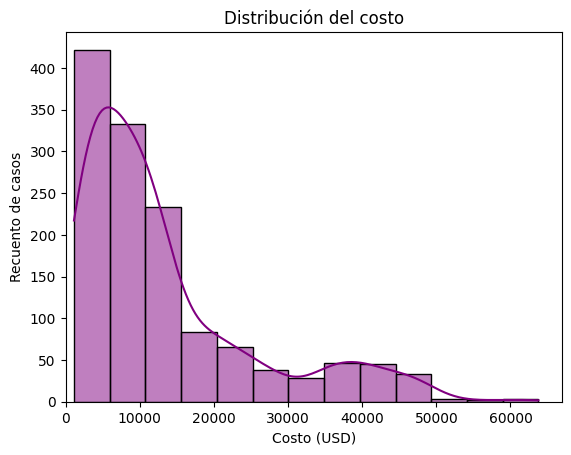

In [ ]:
sns.histplot(data=seguros, x='Costo', kde=True, bins=13, color='purple')

plt.title('Distribución del costo')
plt.xlabel('Costo (USD)')
plt.ylabel('Recuento de casos')
plt.xlim(0)

plt.show()

Teniendo en cuenta el gráfico de distribución de costo, podemos afirmar que la mayoría de los usuarios pagan hasta 15000 USD anuales, con un mínimo cercano a 0 y un máximo cercano a 60000 USD anuales.

Verificamos, como habíamos observado en la descripción de las estadísticas de esta columna, que presenta una desviación hacia la derecha. Esto significa que la mayor cantidad de datos se concentra en los valores más bajos en cuanto al costo de la póliza.

####**Conclusiones luego del Data Wrangling**:
El dataframe consta de 9 columnas y 1338 registros.

La edad promedio es de 39 años. El mínimo es 18 años y el máximo es 64 años. El sexo se distribuye de manera equitativa. El IMC promedio es de 30.51. El mínimo es de 16 y el máximo de 47. Casi la mitad de los afiliados no tienen hijos, y para los que sí los tienen, la cantidad varía de 1 a 5 en orden decreciente. El 20.4% de la población fuma, mientras que el 79.6% no fuma. La región Sureste presenta ligeramente más registros que las demás. La mayoría de los usuarios pagan hasta 15000 USD anuales, con un máximo cercano a los 60000 USD anuales.

####Guardado del dataframe modificado

Procedemos a guardar un nuevo csv donde se hayan aplicado los cambios realizados, para evitar correr todo el notebook cada vez que queramos trabajar en él.

In [ ]:
# Nombre del nuevo archivo CSV
seguros3 = "seguros_3.csv"

# Combinamos la ruta del directorio y el nombre del nuevo archivo
ruta_seguros3= os.path.join(ruta, seguros3)

# Guardamos el nuevo archivo CSV en la misma ruta
seguros.to_csv(ruta_seguros3, index=False)

###Visualizaciones

In [ ]:
# Cargamos el csv con las modificaciones del Data Wrangling
seguros = pd.read_csv(ruta_seguros3)
seguros.head()

,Edad,IMC,Hijos,Costo,Fumador_cod,Sexo_cod,Región_cod,Rango_Etario,Rango_IMC
0,19,27.900,0,16884.92,1,1,2,15-19,25-29
1,18,33.770,1,1725.55,0,0,1,15-19,30-34
2,28,33.000,3,4449.46,0,0,1,25-29,30-34
3,33,22.705,0,21984.47,0,0,3,30-34,20-24
4,32,28.880,0,3866.86,0,0,3,30-34,25-29


####Relación entre IMC y Edad

<ipython-input-50-9b979dc47fd2>:8: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.boxplot(x='Rango_Etario', y='IMC', data=seguros_sorted, hue='Rango_Etario', palette=colores, legend='auto')


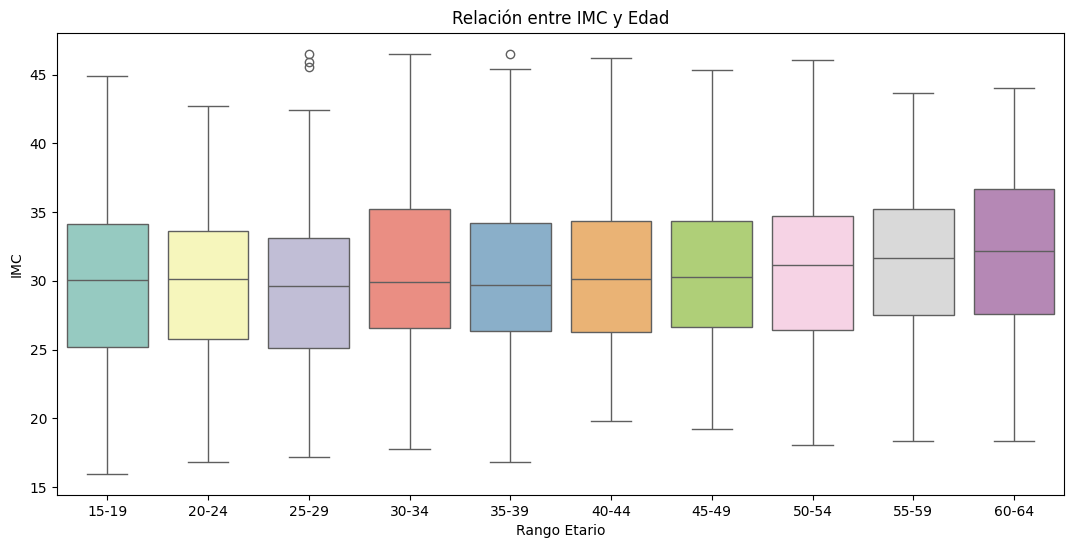

In [ ]:
# Ordenamos el DataFrame por la columna 'Edad'
seguros_sorted = seguros.sort_values(by='Edad')

# Paleta de colores
colores = sns.color_palette('Set3')

plt.figure(figsize=(13, 6))
sns.boxplot(x='Rango_Etario', y='IMC', data=seguros_sorted, hue='Rango_Etario', palette=colores, legend='auto')
plt.title('Relación entre IMC y Edad')

plt.xlabel('Rango Etario')
plt.ylabel('IMC')

plt.show()


Detalle de los rangos de IMC:

* 18 a 25: Peso normal para la talla
* 25.1 a 30: Sobrepeso
* Mayor a 30: Obesidad

Se observa que para todos los grupos etarios la mediana de IMC se ubica en torno a 30; esto indica posible obesidad. Además, se observa un leve incremento de la mediana del IMC en las personas mayores a 50 años.

 Estas observaciones coinciden con el polígono de frecuencia, en el cual pudimos observar que la mayor concentración de casos se encuentra en torno a los 30 kg/m².

####Relación entre IMC y Tabaquismo (fumadores y no fumadores)

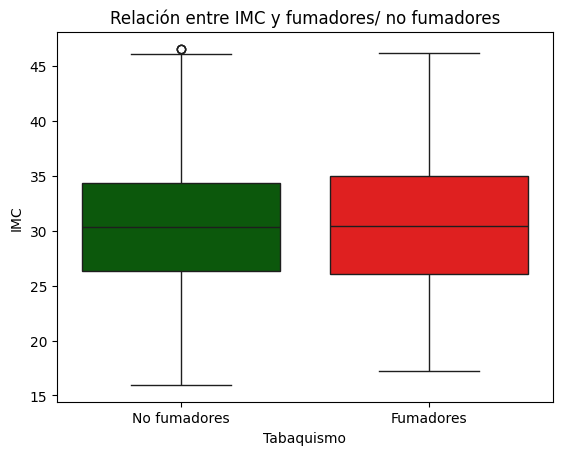

In [ ]:
labels = ['No fumadores','Fumadores']
colors = ['darkgreen', 'red']

sns.boxplot(data=seguros, y='IMC', x="Fumador_cod", hue= 'Fumador_cod', palette=colors)
plt.title("Relación entre IMC y fumadores/ no fumadores")
plt.xlabel('Tabaquismo')
plt.ylabel('IMC')
plt.legend().remove()

# Cambiamos las etiquetas del eje x
plt.xticks([0, 1], labels=labels)

plt.show()

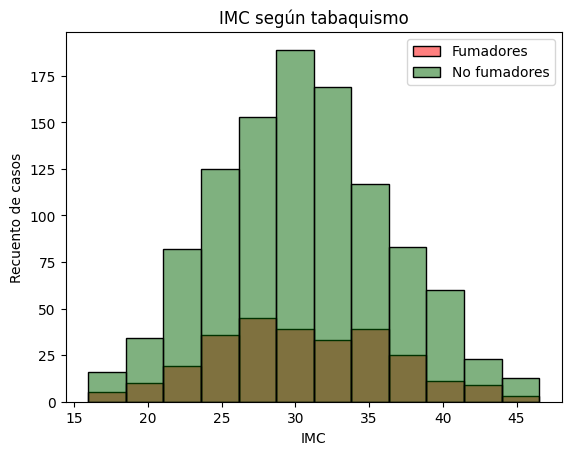

In [ ]:
# Distribución del IMC según tabaquismo
labels = ['Fumadores','No fumadores']
colors = ['darkgreen','red']

sns.histplot(data=seguros, x='IMC', bins=12, hue='Fumador_cod', palette=colors)
plt.title('IMC según tabaquismo')
plt.legend(labels=labels)
plt.xlabel('IMC')
plt.ylabel('Recuento de casos')

plt.show()

En el gráfico de boxplot no se observan diferencias significativas en el IMC relacionadas con el tabaquismo, ubicándose la mediana cercana a los 30 kg/m².

Del mismo modo, en el gráfico de barras se observa que la mayor cantidad de casos presenta un IMC en torno a los 30 kg/m². En concordancia con lo observado en el gráfico de torta, existen muchos más casos de no fumadores que fumadores.

####Relación entre tabaquismo, IMC y edad

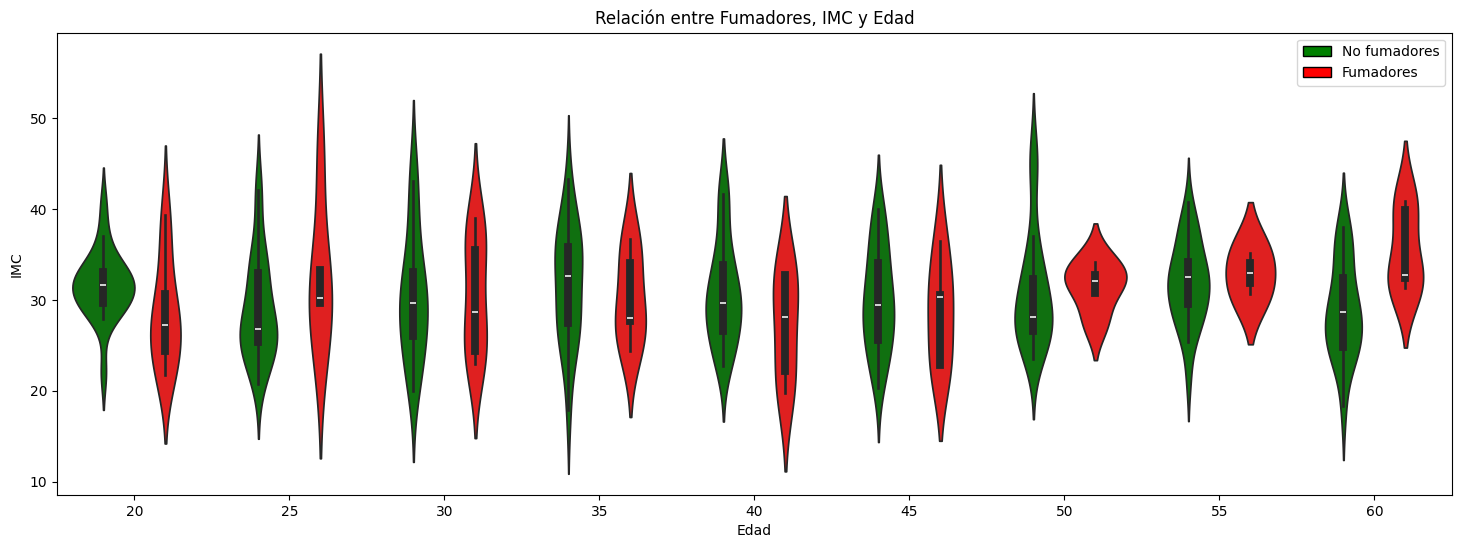

In [ ]:
labels = ['No fumadores', 'Fumadores']
colors = ['green','red']

# Creamos la leyenda personalizada
legend_patches = [plt.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=color) for color in colors]

plt.figure(figsize= (18,6))
sns.violinplot(x='Edad', y='IMC', hue='Fumador_cod', data=seguros[seguros['Edad'].isin([15,20,25,30,35,40,45,50,55,60,65])], palette=colors)
plt.title('Relación entre Fumadores, IMC y Edad')

plt.xlabel('Edad')
plt.ylabel('IMC')

# Agregamos la leyenda personalizada con las etiquetas
plt.legend(legend_patches, labels)

plt.show()

Se observa que a partir de los 50 años el IMC aumenta significativamente en los fumadores. Fuera de este detalle, no se observa relación significativa entre la edad y el IMC.

####Relación entre tabaquismo, edad y costo del seguro médico

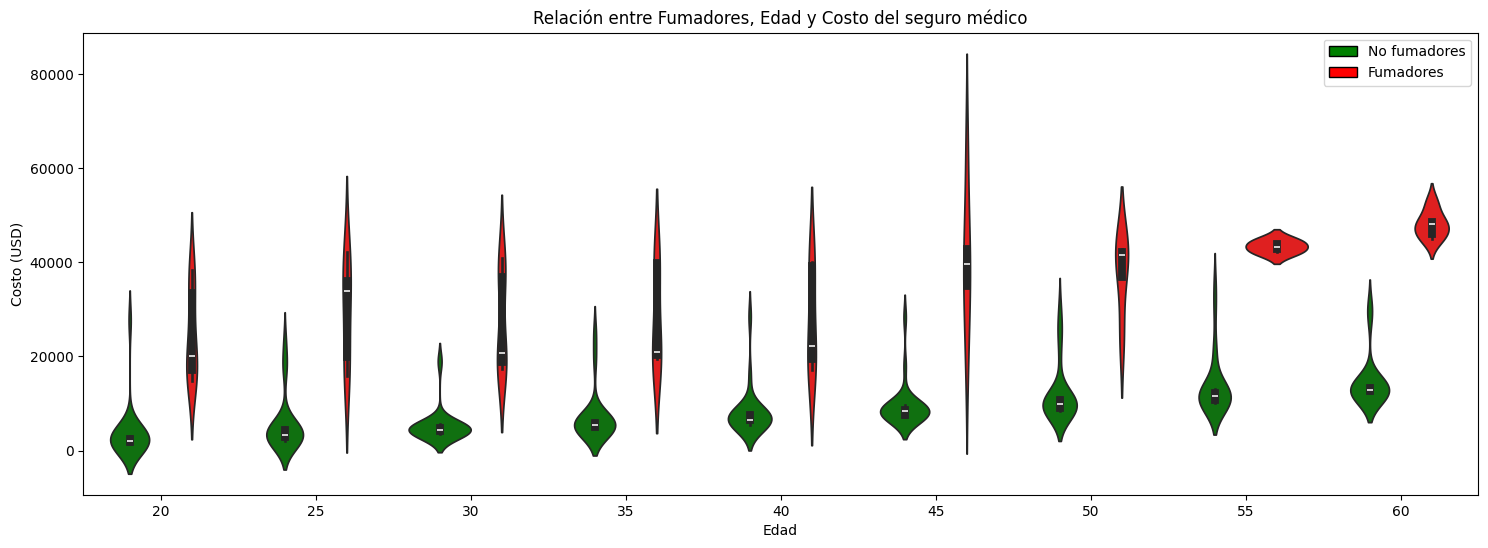

In [ ]:
labels = ['No fumadores', 'Fumadores']
colors = ['green','red']

# Creamos la leyenda personalizada
legend_patches = [plt.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=color) for color in colors]

plt.figure(figsize=(18, 6))
sns.violinplot(x='Edad', y='Costo', hue='Fumador_cod', data=seguros[seguros['Edad'].isin([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])], palette=colors)
plt.title('Relación entre Fumadores, Edad y Costo del seguro médico')

plt.xlabel('Edad')
plt.ylabel('Costo (USD)')

# Agregamos la leyenda personalizada con las etiquetas
plt.legend(legend_patches, labels)

plt.show()




Se observa que el costo del seguro médico aumenta a medida que la persona es mayor. Por otra parte, los fumadores pagan una póliza más alta que los no fumadores, en todos los rangos etarios analizados.

####Relación entre tabaquismo, rango de IMC y costo del seguro médico

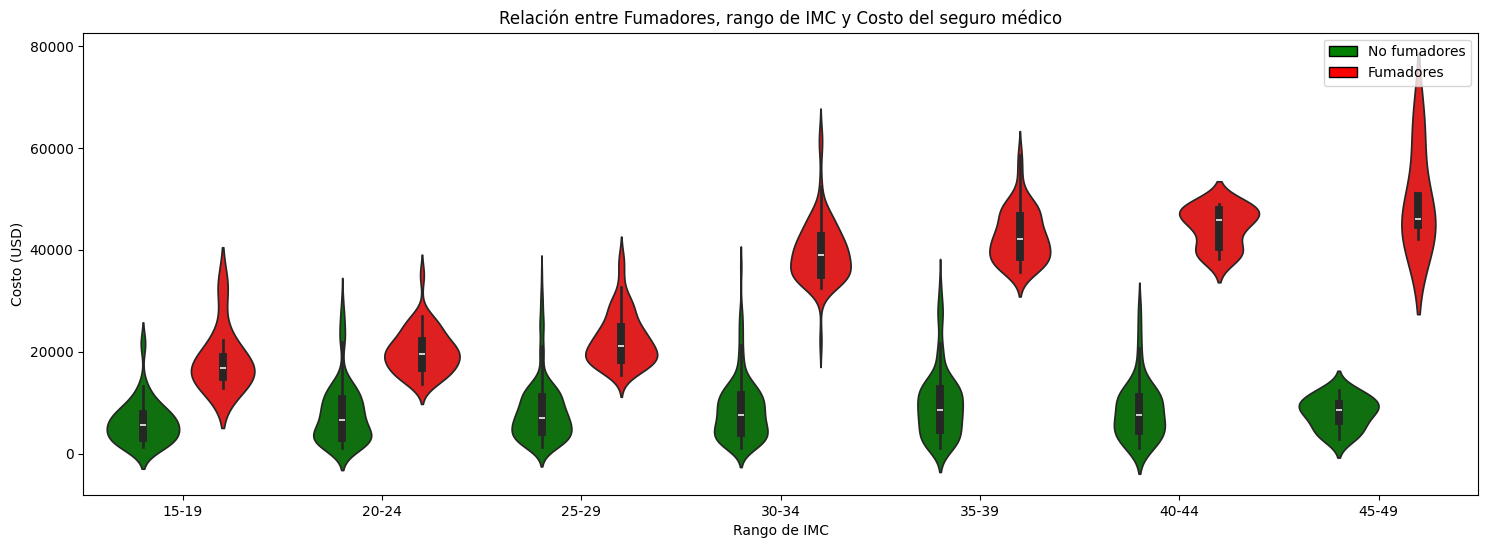

In [ ]:
labels = ['No fumadores', 'Fumadores']
colors = ['green','red']

# Creamos la leyenda personalizada
legend_patches = [plt.Rectangle((0, 0), 1, 1, edgecolor='black', facecolor=color) for color in colors]

# Definimos el orden de los rangos de IMC
order = ['15-19','20-24','25-29','30-34','35-39','40-44','45-49']

plt.figure(figsize=(18, 6))
sns.violinplot(x='Rango_IMC', y='Costo', hue='Fumador_cod', data=seguros[seguros['Rango_IMC'].isin(order)], palette=colors, order=order)
plt.title('Relación entre Fumadores, rango de IMC y Costo del seguro médico')

plt.xlabel('Rango de IMC')
plt.ylabel('Costo (USD)')

# Agregamos la leyenda personalizada con las etiquetas
plt.legend(legend_patches, labels)

plt.show()


A partir de este gráfico podemos observar que el hecho de ser fumador o no fumador tiene una gran incidencia en el valor del seguro. En los casos de fumadores, observamos que a partir del rango IMC 30 (obesidad), el costo del seguro aumenta considerablemente. Una vez superado el IMC 30, el grado de obesidad no es una variable determinante para el costo del seguro médico.

En el caso de los no fumadores, el rango de IMC no parece tener una incidencia significativa en el valor del seguro.

#### Costo del seguro médico según tabaquismo

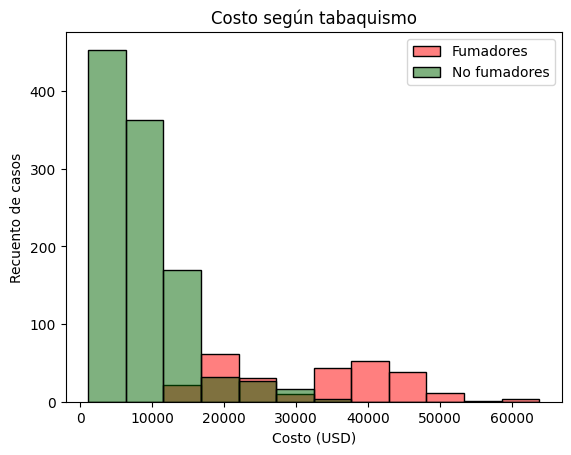

In [ ]:
# Distribución del costo según tabaquismo
labels = ['Fumadores', 'No fumadores']
colors = ['darkgreen', 'red']

sns.histplot(data=seguros, x='Costo', bins=12, hue='Fumador_cod', palette=colors)
plt.title('Costo según tabaquismo')
plt.legend(labels=labels)
plt.xlabel('Costo (USD)')
plt.ylabel('Recuento de casos')

plt.show()

En este gráfico se evidencia que los fumadores pagan las pólizas más altas.

###Matriz de correlación

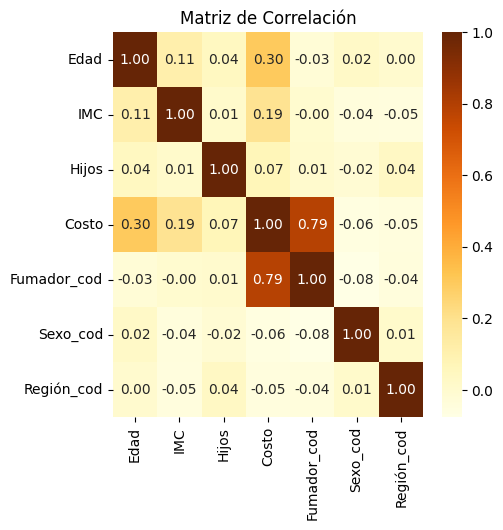

In [ ]:
# Creamos la matriz de correlación

correlation_matrix = seguros.corr(numeric_only=True)

# Visualizamos la matriz de correlación como un mapa de calor
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de Correlación')

plt.show()

A partir de la matriz de correlación, podemos concluir que existe una relación positiva fuerte entre el costo de la póliza y el hecho de ser fumador. La relación de la póliza con la edad es positiva pero débil.

###Regresión lineal

####**Pregunta:** ¿Tiene relación el costo del seguro con el IMC?

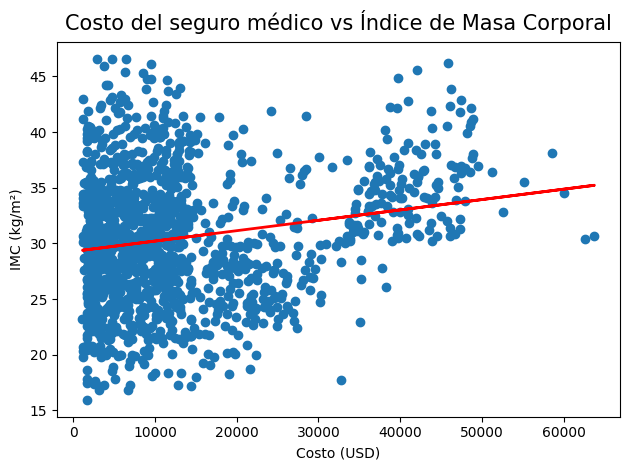

In [ ]:
# Definimos las variables
costo = seguros['Costo']
imc = seguros['IMC']

# Ajustamos una regresión lineal a los datos
coefficients2 = np.polyfit(costo, imc, 1)
b, a = coefficients2

# Creamos una línea de tendencia basada en los coeficientes encontrados
trend_line2 = b * costo + a

# Creamos el gráfico
plt.scatter(costo, imc)
plt.plot(costo, trend_line2, color='red', linewidth=2, label='Línea de Tendencia')

plt.title("Costo del seguro médico vs Índice de Masa Corporal", fontsize=15, verticalalignment='bottom')
plt.xlabel("Costo (USD)")
plt.ylabel("IMC (kg/m²)")

plt.tight_layout()

plt.show()

**Conclusiones:** Se observa una relación positiva leve: a mayor IMC, mayor costo.

####**Pregunta:** ¿Tiene relación el costo del seguro con la edad?

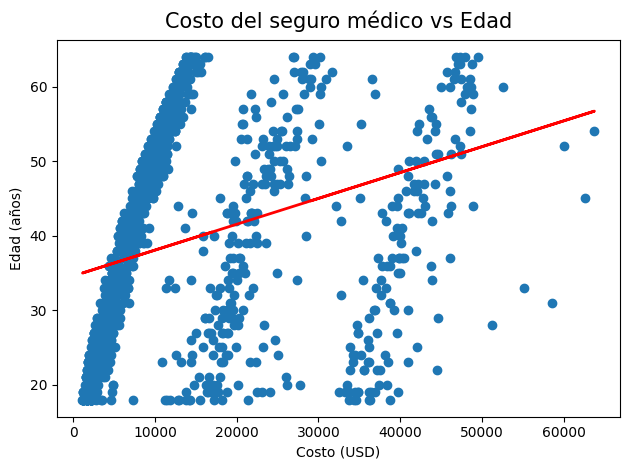

In [ ]:
# Definimos las variables
costo = seguros['Costo']
edad = seguros['Edad']

# Ajustamos una regresión lineal a los datos
coefficients2 = np.polyfit(costo, edad, 1)
b, a = coefficients2

# Creamos una línea de tendencia basada en los coeficientes encontrados
trend_line2 = b * costo + a

# Creamos el gráfico
plt.scatter(costo, edad)
plt.plot(costo, trend_line2, color='red', linewidth=2, label='Línea de Tendencia')

plt.title("Costo del seguro médico vs Edad", fontsize=15, verticalalignment='bottom')
plt.xlabel("Costo (USD)")
plt.ylabel("Edad (años)")

plt.tight_layout()

plt.show()

**Conclusiones:** Se observa una relación positiva: a mayor edad, mayor costo.

###Machine Learning

Debido a que contamos con datos etiquetados, vamos a elegir aplicar un modelo de regresión lineal para intentar desarrollar una fórmula que calcule el precio del seguro a partir de los otros datos con los que contamos. La variable objetivo es una variable numérica continua.

####Modelo 1: validación simple y regresión lineal

In [ ]:
# definimos X e y
X = seguros.drop(['Costo', 'Rango_Etario', 'Rango_IMC'], axis=1)
y = seguros['Costo']

In [ ]:
# Método de selección hacia adelante
sfs_forward = SequentialFeatureSelector(estimator=LinearRegression(),
                  k_features=6,
                  forward=True,
                  floating=False,
                  scoring='r2', # por ser un problema de regresión
                  cv=5) # cantidad de pliegues (ciclos de validación)


#Hacemos el ajuste fit con respecto a nuestros datos
sfs_forward.fit(X, y)

#Seleccionamos las características
selected_features_forward = sfs_forward.k_feature_names_
print("Features seleccionadas:", selected_features_forward)

Features seleccionadas: ('Edad', 'IMC', 'Hijos', 'Fumador_cod', 'Sexo_cod', 'Región_cod')


In [ ]:
# Entrenamos el modelo y evaluamos su rendimiento con las features seleccionadas

modelo_X = seguros[['Edad', 'IMC', 'Hijos', 'Fumador_cod', 'Sexo_cod', 'Región_cod']]
y = seguros['Costo']  # Variable objetivo (dependiente)

#Dividimos el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(modelo_X, y, test_size=0.2, random_state=42) # randomstate: cantidad de veces que se repite

# Creamos un modelo de regresión lineal
model = LinearRegression()

#Ajuste de datos
model.fit(X_train, y_train)

# Predecimos los valores en el conjunto de entrenamiento y de prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Coefecientes
coeff_df = pd.DataFrame(model.coef_, ['Edad', 'IMC', 'Hijos', 'Fumador_cod', 'Sexo_cod', 'Región_cod'], columns=['Coeficientes "a"'])
print(coeff_df)
print('Coeficiente "b":',model.intercept_)

             Coeficientes "a"
Edad               256.454401
IMC                346.942302
Hijos              426.601469
Fumador_cod      23616.927661
Sexo_cod           -30.059859
Región_cod        -134.632052
Coeficiente "b": -12423.46531917311


####Evaluamos las métricas del modelo de regresión lineal simple

In [ ]:
#MAE, MSE, RMSE, r2

#Train
mae_train = round(mean_absolute_error(y_train, y_train_pred),4)
mse_train = round(mean_squared_error(y_train, y_train_pred),4)
rmse_train = round(np.sqrt(mse_train),4)
r2_train = round(r2_score(y_train, y_train_pred),4)

# Test
mae_test = round(mean_absolute_error(y_test, y_test_pred),4)
mse_test = round(mean_squared_error(y_test, y_test_pred),4)
rmse_test = round(np.sqrt(mse_test),4)
r2_test = round(r2_score(y_test, y_test_pred),4)

print('Métricas del conjunto de entrenamiento')
print(f"MAE_train : {mae_train} (USD)")
print(f"MSE_train : {mse_train}") # media de los errores al cuadrado entre las predicciones y los valores reales
print(f"RMSE_train: {rmse_train}") # raiz cuadrada del MSE
print(f"R²_train : {r2_train}") # tiene que ser cercano a 1

print('---------------------------')
print('Métricas del conjunto de prueba')
print(f"MAE_test : {mae_test} USD")
print(f"MSE_test : {mse_test}")
print(f"RMSE_test: {rmse_test}")
print(f"R²_test : {r2_test}")

Métricas del conjunto de entrenamiento
MAE_train : 4216.9577 (USD)
MSE_train : 37129771.6761
RMSE_train: 6093.4204
R²_train : 0.7428
---------------------------
Métricas del conjunto de prueba
MAE_test : 4273.2718 USD
MSE_test : 35595560.6458
RMSE_test: 5966.2015
R²_test : 0.7707


##Modelo 2: validación simple, PCA y regresión lineal

In [ ]:
# definimos X2 e y2
X2 = seguros.drop(['Costo', 'Rango_Etario', 'Rango_IMC'], axis=1)
y2 = seguros['Costo']

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y prueba (validación simple)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
# Normalización de los datos para aplicar PCA
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

In [ ]:
# Creamos un modelo de regresión lineal
model = LinearRegression()

In [ ]:
# Configuramos el método de selección de características hacia adelante
sfs_forward2 = SequentialFeatureSelector(estimator=model,
                                        k_features=6,
                                        forward=True,
                                        floating=False,
                                        scoring='r2',
                                        cv=5)

In [ ]:
# Ajustamos el modelo al conjunto de entrenamiento
sfs_forward2.fit(X_train_scaled2, y_train2)


SequentialFeatureSelector(estimator=LinearRegression(), k_features=(6, 6),
                          scoring='r2')

In [ ]:
# Obtenemos las características seleccionadas
selected_features = np.array(X2.columns)[list(sfs_forward2.k_feature_idx_)]
print(selected_features)

['Edad' 'IMC' 'Hijos' 'Fumador_cod' 'Sexo_cod' 'Región_cod']


In [ ]:
# Aplicamos PCA
pca = PCA()
X_train_pca2 = pca.fit_transform(X_train_scaled2)
X_test_pca2 = pca.transform(X_test_scaled2)

In [ ]:
# Obtenemos la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:\n", explained_variance)

Varianza explicada por cada componente:
 [0.19149861 0.17981651 0.17298333 0.16170349 0.15222555 0.14177251]


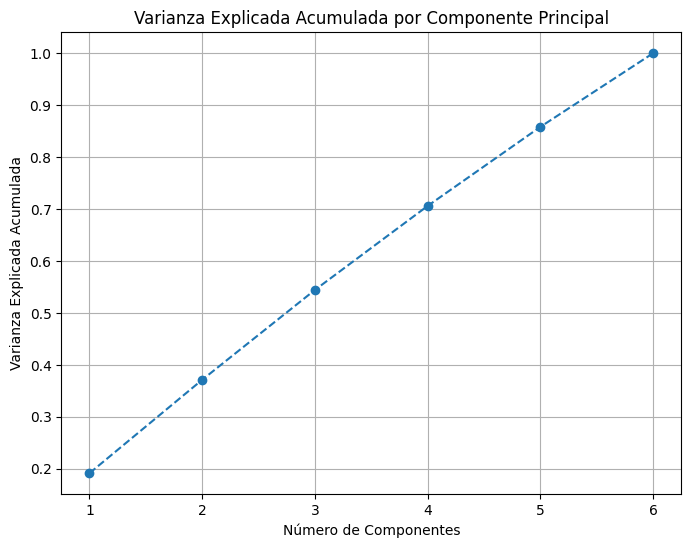

In [ ]:
# Gráfico de varianza explicada de acuerdo a la cantidad de componentes

# Varianza explicada acumulada
cumulative_variance_ratio = np.cumsum(explained_variance)

# Gráfico de varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.grid(True)
plt.show()

Podemos observar que 5 de los 6 componentes explican más del 80% de la varianza.

In [ ]:
# Ajustamos las dimensiones del DataFrame con los coeficientes de cada variable para cada componente principal
principal_components = pca.components_

In [ ]:
# Creamos un DataFrame con los coeficientes de cada variable para cada componente principal
df_loadings = pd.DataFrame(principal_components.T, columns=[f'Componente {i+1}' for i in range(len(explained_variance))])
df_loadings['Variable Original'] = X2.columns

In [ ]:
# Añadimos los nombres de las variables originales
df_loadings['Variable Original'] = X2.columns

In [ ]:
df_loadings.columns

Index(['Componente 1', 'Componente 2', 'Componente 3', 'Componente 4',
       'Componente 5', 'Componente 6', 'Variable Original'],
      dtype='object')

In [ ]:
# Colocamos la columna Variable Original al principio del dataframe
df_loadings = df_loadings [['Variable Original', 'Componente 1', 'Componente 2', 'Componente 3', 'Componente 4','Componente 5', 'Componente 6']]

In [ ]:
# Mostramos el dataframe creado para ver la ponderacion de cada variable en los distintos componentes
df_loadings

,Variable Original,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6
0,Edad,-0.696106,0.139994,-0.022773,0.002517,-0.059304,0.701281
1,IMC,-0.530327,0.316450,-0.425376,-0.214336,0.226447,-0.583480
2,Hijos,-0.262030,0.265039,0.560876,0.669042,-0.080493,-0.303999
3,Fumador_cod,0.335047,0.621373,-0.019204,0.098666,0.650088,0.262529
4,Sexo_cod,-0.139068,-0.610643,-0.247754,0.473419,0.567256,0.022083
5,Región_cod,-0.184209,-0.225889,0.664984,-0.522087,0.440832,-0.077008


In [ ]:
# Transformamos los datos con las características seleccionadas
X_train_selected2 = sfs_forward2.transform(X_train_scaled2)
X_test_selected2 = sfs_forward2.transform(X_test_scaled2)

In [ ]:
# Aplicamos PCA a los datos transformados con las características seleccionadas (con 10 componentes)
pca_selected = PCA(n_components=6)
X_train_pca_selected2 = pca_selected.fit_transform(X_train_selected2)
X_test_pca_selected2 = pca_selected.transform(X_test_selected2)

In [ ]:
# Ajustamos el modelo de regresión con los datos transformados seleccionados y con PCA
model.fit(X_train_pca_selected2, y_train2)

LinearRegression()

In [ ]:
# Realizamos predicciones de los valores en el conjunto de entrenamiento y de prueba
y_train_pred2 = model.predict(X_train_pca_selected2)
y_test_pred2 = model.predict(X_test_pca_selected2)

####Evaluamos las métricas del modelo de regresión lineal simple

In [ ]:
#MAE, MSE, RMSE, r2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Train
mae_train = round(mean_absolute_error(y_train2, y_train_pred2),4)
mse_train = round(mean_squared_error(y_train2, y_train_pred2),4)
rmse_train = round(np.sqrt(mse_train),4)
r2_train = round(r2_score(y_train2, y_train_pred2),4)

# Test
mae_test = round(mean_absolute_error(y_test2, y_test_pred2),4)
mse_test = round(mean_squared_error(y_test2, y_test_pred2),4)
rmse_test = round(np.sqrt(mse_test),4)
r2_test = round(r2_score(y_test2, y_test_pred2),4)

print('Métricas del conjunto de entrenamiento')
print(f"MAE_train : {mae_train} (USD)")
print(f"MSE_train : {mse_train}")
print(f"RMSE_train: {rmse_train}")
print(f"R²_train : {r2_train}")

print('---------------------------')
print('Métricas del conjunto de prueba')
print(f"MAE_test : {mae_test} (USD)")
print(f"MSE_test : {mse_test}")
print(f"RMSE_test: {rmse_test}")
print(f"R²_test : {r2_test}")

Métricas del conjunto de entrenamiento
MAE_train : 4216.9577 (USD)
MSE_train : 37129771.6761
RMSE_train: 6093.4204
R²_train : 0.7428
---------------------------
Métricas del conjunto de prueba
MAE_test : 4273.2718 (USD)
MSE_test : 35595560.6458
RMSE_test: 5966.2015
R²_test : 0.7707


**Las métricas del modelo con PCA son idénticas a las del modelo sin PCA. La aplicación de PCA no produjo mejoras en el modelo.**

##Modelo 3: validación simple, PCA, Halving Random Search CV y XGB Regressor


In [ ]:
# definimos X3 e y3
X3 = seguros.drop(['Costo', 'Rango_Etario', 'Rango_IMC'], axis=1)
y3 = seguros['Costo']

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y prueba (validación simple)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [ ]:
# Normalización de los datos para aplicar PCA
scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train3)
X_test_scaled3 = scaler.transform(X_test3)

In [ ]:
# Aplicamos PCA
pca = PCA()
X_train_pca3 = pca.fit_transform(X_train_scaled3)
X_test_pca3 = pca.transform(X_test_scaled3)

In [ ]:
import xgboost as xgb

model3 = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]}

In [ ]:
random_search = HalvingRandomSearchCV(model3, param_grid, cv=5, factor=3, random_state=42)

In [ ]:
random_search.fit(X_train_pca3, y_train3, verbose=1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=107. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two sampl

HalvingRandomSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=No...
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...),
                      param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                           'max_depth': [3, 5, 7],
                                           'n_estimators': [50, 100, 200]},
                      random_state=42)

In [ ]:
best_params = random_search.best_params_
final_model3= xgb.XGBRegressor(**best_params)
final_model3.fit(X_train_pca3, y_train3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print("Mejores parametros", random_search.best_params_)

Mejores parametros {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}


In [ ]:
# 4 segundos
# Ajustamos el modelo de regresión con los datos transformados seleccionados y con PCA aplicando XGBoost
import xgboost as xgb

regressor3 = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1, # Término de regularización L1 en los pesos
    gamma=0, #Reducción mínima de pérdida requerida para realizar una partición adicional en un nodo hoja del árbol
    max_depth=3,
    learning_rate= 0.01,
    random_state = 42
)

# Realizamos el fit
regressor3.fit(X_train_pca3, y_train3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Realizamos las predicciones de los valores en el conjunto de entrenamiento y de prueba
y_train_pred3 = regressor3.predict(X_train_pca3)
y_test_pred3 = regressor3.predict(X_test_pca3)

####Evaluamos las métricas del modelo con XGB Regressor

In [ ]:
#MAE, MSE, RMSE, r2

#Train
mae_train = round(mean_absolute_error(y_train3, y_train_pred3),4)
mse_train = round(mean_squared_error(y_train3, y_train_pred3),4)
rmse_train = round(np.sqrt(mse_train),4)
r2_train = round(r2_score(y_train3, y_train_pred3),4)

# Test
mae_test = round(mean_absolute_error(y_test3, y_test_pred3),4)
mse_test = round(mean_squared_error(y_test3, y_test_pred3),4)
rmse_test = round(np.sqrt(mse_test),4)
r2_test = round(r2_score(y_test3, y_test_pred3),4)

print('Métricas del conjunto de entrenamiento')
print(f"MAE_train : {mae_train} (USD)")
print(f"MSE_train : {mse_train}")
print(f"RMSE_train: {rmse_train}")
print(f"R²_train : {r2_train}")

print('---------------------------')
print('Métricas del conjunto de prueba')
print(f"MAE_test : {mae_test} (USD)")
print(f"MSE_test : {mse_test}")
print(f"RMSE_test: {rmse_test}")
print(f"R²_test : {r2_test}")

Métricas del conjunto de entrenamiento
MAE_train : 5250.4138 (USD)
MSE_train : 47870101.9532
RMSE_train: 6918.8223
R²_train : 0.6683
---------------------------
Métricas del conjunto de prueba
MAE_test : 5776.1117 (USD)
MSE_test : 58364368.606
RMSE_test: 7639.6576
R²_test : 0.6241


**El rendimiento de este modelo fue menor a los anteriores.**

##Modelo 4: validación simple y Gradient Boosting Regressor


In [ ]:
# definimos X4 e y4
X4 = seguros.drop(['Costo', 'Rango_Etario', 'Rango_IMC'], axis=1)
y4 = seguros['Costo']

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y prueba (validación simple)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)

In [ ]:
#  Ajustamos el modelo de regresión con los datos transformados seleccionados y con PCA aplicando el Boosting Regressor

# Creamos un regresor GradientBoosting
gbrt4 = GradientBoostingRegressor(random_state=42)

In [ ]:
# Entrenamos el modelo con la búsqueda de hiperparámetros
gbrt4.fit(X_train4, y_train4)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Realizamos las predicciones de los valores en el conjunto de entrenamiento y de prueba
y_train_pred4 = gbrt4.predict(X_train4)
y_test_pred4 = gbrt4.predict(X_test4)

####Evaluamos las métricas del modelo con GBR

In [ ]:
#MAE, MSE, RMSE, r2

#Train
mae_train = round(mean_absolute_error(y_train4, y_train_pred4),4)
mse_train = round(mean_squared_error(y_train4, y_train_pred4),4)
rmse_train = round(np.sqrt(mse_train),4)
r2_train = round(r2_score(y_train4, y_train_pred4),4)

# Test
mae_test = round(mean_absolute_error(y_test4, y_test_pred4),4)
mse_test = round(mean_squared_error(y_test4, y_test_pred4),4)
rmse_test = round(np.sqrt(mse_test),4)
r2_test = round(r2_score(y_test4, y_test_pred4),4)

print('Métricas del conjunto de entrenamiento')
print(f"MAE_train : {mae_train} (USD)")
print(f"MSE_train : {mse_train}")
print(f"RMSE_train: {rmse_train}")
print(f"R²_train : {r2_train}")

print('---------------------------')
print('Métricas del conjunto de prueba')
print(f"MAE_test : {mae_test} (USD)")
print(f"MSE_test : {mse_test}")
print(f"RMSE_test: {rmse_test}")
print(f"R²_test : {r2_test}")

Métricas del conjunto de entrenamiento
MAE_train : 2094.9413 (USD)
MSE_train : 14571978.5781
RMSE_train: 3817.3261
R²_train : 0.899
---------------------------
Métricas del conjunto de prueba
MAE_test : 2398.376 (USD)
MSE_test : 19382071.0163
RMSE_test: 4402.5074
R²_test : 0.8752


**El rendimiento de este modelo fue el mejor hasta ahora, con mayor r2 y el menor MAE.**

##Modelo 5: validación simple y XGBoost Regressor

In [ ]:
# definimos X5 e y5
X5 = seguros.drop(['Costo', 'Rango_Etario', 'Rango_IMC'], axis=1)
y5 = seguros['Costo']

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y prueba (validación simple)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [ ]:
#  Creamos el modelo de regresión con los datos transformados seleccionados aplicando el Boosting Regressor
import xgboost as xgb


regressor5 = xgb.XGBRegressor(
    n_estimators=80,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    random_state = 42
)

# Realizamos el fit
regressor5.fit(X_train5, y_train5)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Realizamos las predicciones en ambos conjuntos
y_train_pred5 = regressor5.predict(X_train5)
y_test_pred5 = regressor5.predict(X_test5)

####Evaluamos las métricas del modelo con GBR

In [ ]:
#MAE, MSE, RMSE, r2

#Train
mae_train = round(mean_absolute_error(y_train5, y_train_pred5),4)
mse_train = round(mean_squared_error(y_train5, y_train_pred5),4)
rmse_train = round(np.sqrt(mse_train),4)
r2_train = round(r2_score(y_train5, y_train_pred5),4)

# Test
mae_test = round(mean_absolute_error(y_test5, y_test_pred5),4)
mse_test = round(mean_squared_error(y_test5, y_test_pred5),4)
rmse_test = round(np.sqrt(mse_test),4)
r2_test = round(r2_score(y_test5, y_test_pred5),4)

print('Métricas del conjunto de entrenamiento')
print(f"MAE_train : {mae_train} (USD)")
print(f"MSE_train : {mse_train}")
print(f"RMSE_train: {rmse_train}")
print(f"R²_train : {r2_train}")

print('---------------------------')
print('Métricas del conjunto de prueba')
print(f"MAE_test : {mae_test} (USD)")
print(f"MSE_test : {mse_test}")
print(f"RMSE_test: {rmse_test}")
print(f"R²_test : {r2_test}")

Métricas del conjunto de entrenamiento
MAE_train : 1937.2778 (USD)
MSE_train : 11691053.3699
RMSE_train: 3419.2182
R²_train : 0.919
---------------------------
Métricas del conjunto de prueba
MAE_test : 2424.4962 (USD)
MSE_test : 19401709.1631
RMSE_test: 4404.7371
R²_test : 0.875


**El rendimiento del modelo con Regressor es muy bueno, y no presenta overfitting ni underfitting**

##Importancia de las variables para el algoritmo

**Se calcula la importancia de cada variable en el modelo 5, que fue el de mejor rendimiento.**

In [ ]:
feature_importances = pd.DataFrame(regressor5.feature_importances_, index=['Edad', 'IMC', 'Hijos', 'Fumador_cod', 'Sexo_cod', 'Región_cod'], columns=['Importance'])

# Ordenamos en orden descendente por la columna 'Importance'
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Imprimimos la lista ordenada
print(feature_importances_sorted)

             Importance
Fumador_cod    0.933600
IMC            0.027375
Edad           0.022453
Hijos          0.007773
Región_cod     0.005295
Sexo_cod       0.003504


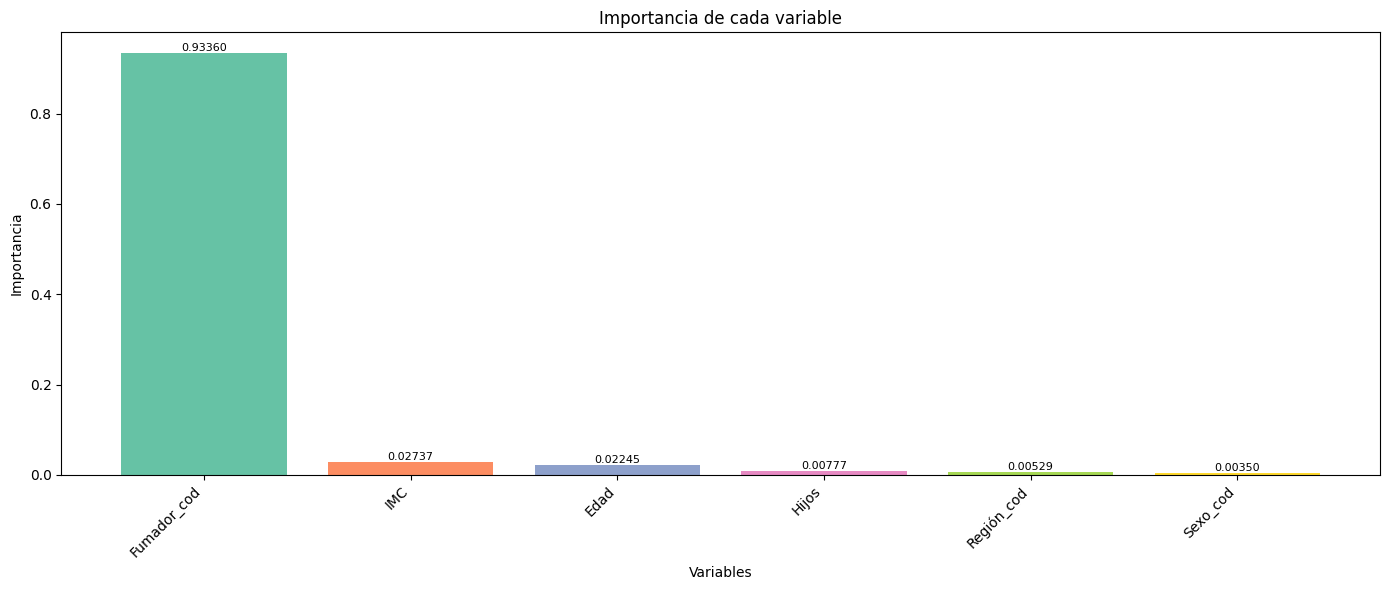

In [ ]:
# Utilizamos el DataFrame ordenado
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Elegimos la paleta de colores de seaborn "Set2"
colors = sns.color_palette("Set2", len(feature_importances_sorted))

# Creamos un gráfico de barras con colores diferentes
plt.figure(figsize=(14, 6))
bars = plt.bar(feature_importances_sorted.index, feature_importances_sorted['Importance'], color=colors)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Importancia de cada variable')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor legibilidad

# Agregamos el valor numérico a cada barra
for bar, value in zip(bars, feature_importances_sorted['Importance']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.5f}',
             ha='center', va='bottom', fontsize=8, color='black')


plt.tight_layout()

# Mostramos el gráfico
plt.show()


#**Conclusiones**

Se probaron 5 modelos diferentes para intentar predecir el costo del seguro médico a partir de otras variables que figuraban en nuestro dataframe. El mejor resultado se obtuvo en el modelo número 5, que combinaba la aplicación de **Validación Simple + XGBoost Regressor**.

Luego de varias pruebas, **se logró desarrollar un modelo que logra predecir el costo anual del seguro médico con un error absoluto promedio de 2180.90 USD.**

El coeficiente de determinación (r2) arrojó un valor de 0.92; esto indica que el modelo de regresión generado explica aproximadamente el 92% de la variabilidad total del costo del seguro. De esto se desprende:

* Muy Buen Ajuste del Modelo: Un r2 de 0.92 es muy alto y sugiere que el modelo de regresión lineal se ajusta muy bien a los datos. La mayoría de la fluctuación en la variable dependiente ha sido capturada por el modelo.

* Alta Capacidad Predictiva: El modelo es capaz de hacer predicciones precisas sobre la variable dependiente, al menos dentro del rango de datos observados. En este sentido, se pudo observar que el MAE (Error Absoluto Medio, por sus siglas en inglés) fue de 1937.28 USD en el conjunto de entrenamiento y de 2424,50 USD en el conjunto de prueba. El MAE es una medida de la magnitud promedio de los errores entre las predicciones y los valores observados en un modelo de regresión. Este MAE significa que, en promedio, las predicciones del modelo difieren en aproximadamente 2180.90 USD del costo real observado. Este valor, si bien es elevado en relación con el costo que se ubica en la mediana del dataframe (con un valor de 9382.03 USD), logró disminuirse considerablemente casi a la mitad a medida que se probaron los diferentes modelos, partiendo de un valor de 4245.11 USD y terminando con 2180.90 USD en el modelo 5.

* Fuerte Relación Lineal: Dado que el r2 se basa en la relación lineal entre las variables, un valor alto también indica una fuerte relación lineal entre las variables independientes y la variable dependiente.

Paralelamente, se observó que el valor del r2 en el conjunto de entrenamiento fue de 0.919, mientras que en el conjunto de prueba fue de 0.875. Al ser valores muy similares, se corrobora que no existe subajuste ni sobreajuste en el modelo.

**A diferencia de lo planteado en la hipótesis, se observa que, si bien la edad es un factor influyente, el tabaquismo es la variable más importante para predecir el costo del seguro médico.**

**Por otra parte, el IMC resultó ser el segundo factor de mayor importancia, seguido por la edad, la cantidad de hijos, la región y, finalmente, el sexo del afiliado.**
